In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import io
import os
import glob



In [7]:
folder_path = r'C:\Users\Admin\Desktop\LSTM' 
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
csv_files.sort()
dataframes = [pd.read_csv(file) for file in csv_files[:7]]

merged_df = pd.concat(dataframes, ignore_index=True)
merged_df.to_csv('merged_final.csv', index=False)
print(" Merged file saved as 'merged_final.csv'")


 Merged file saved as 'merged_final.csv'


In [8]:
# Calculate deltas in the vehicle frame
df = pd.read_csv('merged_final.csv')
dt = 1 / 50  # 50Hz
df['delta_x_v'] = df['ins_vel_hor_x'] * dt
df['delta_y_v'] = df['ins_vel_hor_y'] * dt
print("Deltas calculated.")

seq_len = 75

# Input and target columns
input_columns = ['SW_pos_obd', 'brake_pressure_obd', 'LatAcc_obd', 'speedo_obd',
                 'VelFR_obd', 'VelFL_obd', 'VelRR_obd', 'VelRL_obd', 'Yawrate_obd', 'ins_yaw']
target_columns = ['ins_vel_hor_x', 'ins_vel_hor_y', 'delta_x_v', 'delta_y_v']

# Split dataset
train_size = int(0.7 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size

train_data = df[:train_size]
val_data = df[train_size:train_size + val_size]
test_data = df[train_size + val_size:]

# Scaling inputs and targets
input_scaler = StandardScaler().fit(train_data[input_columns].values)
target_scaler = StandardScaler().fit(train_data[target_columns].values)
print("Data split and scaled.")

# Dataset class
class SingleStepDataset(Dataset):
    def __init__(self, data, input_columns, target_columns, seq_len, input_scaler, target_scaler):
        self.seq_len = seq_len
        inputs = data[input_columns].values
        targets = data[target_columns].values
        self.inputs = input_scaler.transform(inputs)
        self.targets = target_scaler.transform(targets)

    def __len__(self):
        return len(self.inputs) - self.seq_len

    def __getitem__(self, idx):
        x = self.inputs[idx : idx + self.seq_len]
        y = self.targets[idx + self.seq_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_dataset = SingleStepDataset(train_data, input_columns, target_columns, seq_len, input_scaler, target_scaler)
val_dataset = SingleStepDataset(val_data, input_columns, target_columns, seq_len, input_scaler, target_scaler)
test_dataset = SingleStepDataset(test_data, input_columns, target_columns, seq_len, input_scaler, target_scaler)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Data loaded into DataLoaders.")

# LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Hyperparameters
input_size = len(input_columns)
hidden_size = 64
num_layers = 3
output_size = len(target_columns)
dropout = 0.2
learning_rate = 0.0005
weight_decay = 1e-5
epochs = 50
patience = 10

# Initialize model, loss, optimizer
model = LSTMRegressor(input_size, hidden_size, num_layers, output_size, dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
best_val_loss = np.inf
early_stopping_counter = 0
print("Model initialized.")



Deltas calculated.
Data split and scaled.
Data loaded into DataLoaders.
Model initialized.


In [9]:
# Training loop
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            predictions = model(x_val)
            loss = criterion(predictions, y_val)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Best model saved at epoch {epoch+1}.")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break



Epoch 1/50 - Train Loss: 0.0733, Val Loss: 0.0100
Best model saved at epoch 1.
Epoch 2/50 - Train Loss: 0.0603, Val Loss: 0.0133
Epoch 3/50 - Train Loss: 0.0537, Val Loss: 0.0122
Epoch 4/50 - Train Loss: 0.0492, Val Loss: 0.0101
Epoch 5/50 - Train Loss: 0.0451, Val Loss: 0.0091
Best model saved at epoch 5.
Epoch 6/50 - Train Loss: 0.0438, Val Loss: 0.0099
Epoch 7/50 - Train Loss: 0.0399, Val Loss: 0.0141
Epoch 8/50 - Train Loss: 0.0374, Val Loss: 0.0144
Epoch 9/50 - Train Loss: 0.0361, Val Loss: 0.0086
Best model saved at epoch 9.
Epoch 10/50 - Train Loss: 0.0344, Val Loss: 0.0118
Epoch 11/50 - Train Loss: 0.0337, Val Loss: 0.0118
Epoch 12/50 - Train Loss: 0.0310, Val Loss: 0.0093
Epoch 13/50 - Train Loss: 0.0300, Val Loss: 0.0123
Epoch 14/50 - Train Loss: 0.0290, Val Loss: 0.0106
Epoch 15/50 - Train Loss: 0.0281, Val Loss: 0.0138
Epoch 16/50 - Train Loss: 0.0272, Val Loss: 0.0106
Epoch 17/50 - Train Loss: 0.0263, Val Loss: 0.0112
Epoch 18/50 - Train Loss: 0.0254, Val Loss: 0.0133
Epoc

In [10]:
# Load best model
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()
print("Best model loaded.")

# Predictions
preds, targets = [], []
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        pred = model(x_test).cpu().numpy()
        preds.append(pred)
        targets.append(y_test.numpy())
preds = np.concatenate(preds, axis=0)
targets = np.concatenate(targets, axis=0)
preds_unscaled = target_scaler.inverse_transform(preds)
targets_unscaled = target_scaler.inverse_transform(targets)



Best model loaded.



--- ins_vel_hor_x ---
MSE : 0.0184
RMSE: 0.1356
MAE : 0.0780
R²  : 0.9978


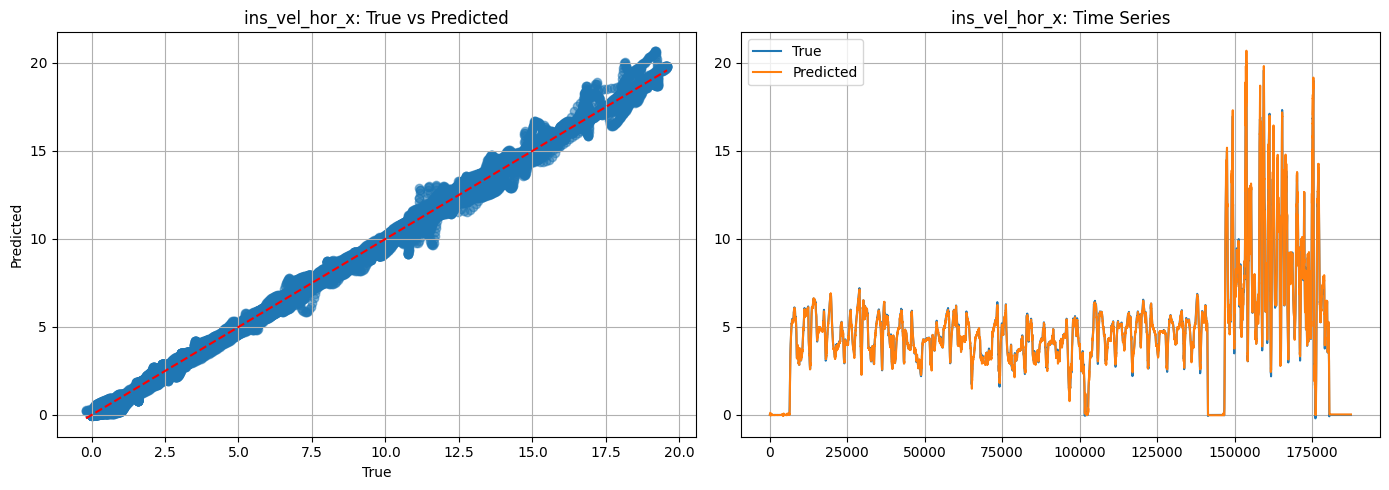


--- ins_vel_hor_y ---
MSE : 0.0012
RMSE: 0.0347
MAE : 0.0126
R²  : 0.8905


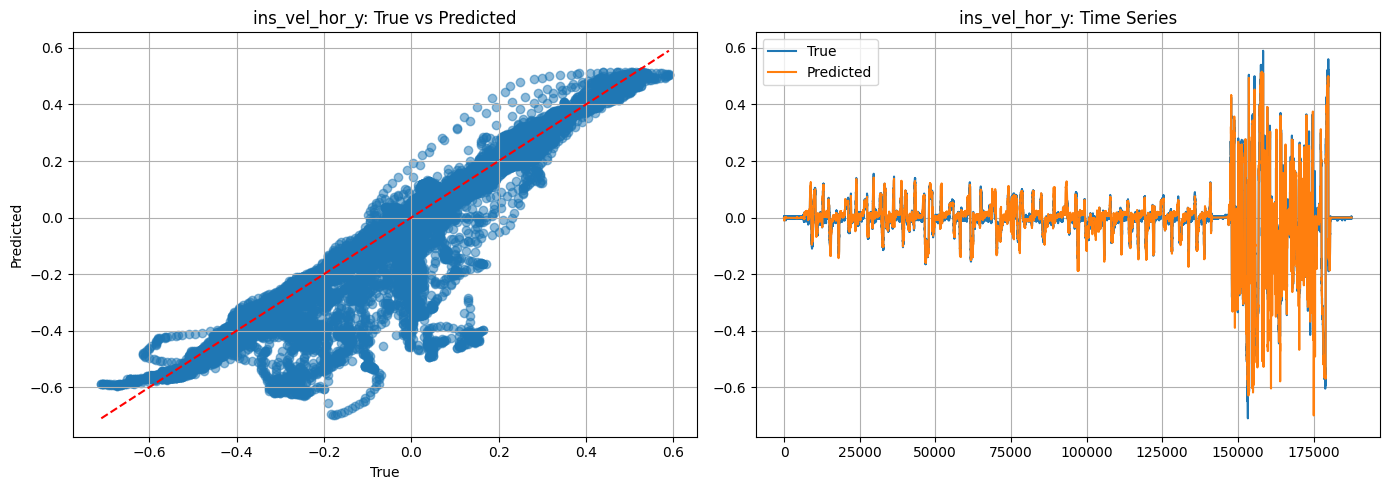


--- delta_x_v ---
MSE : 0.0000
RMSE: 0.0027
MAE : 0.0016
R²  : 0.9978


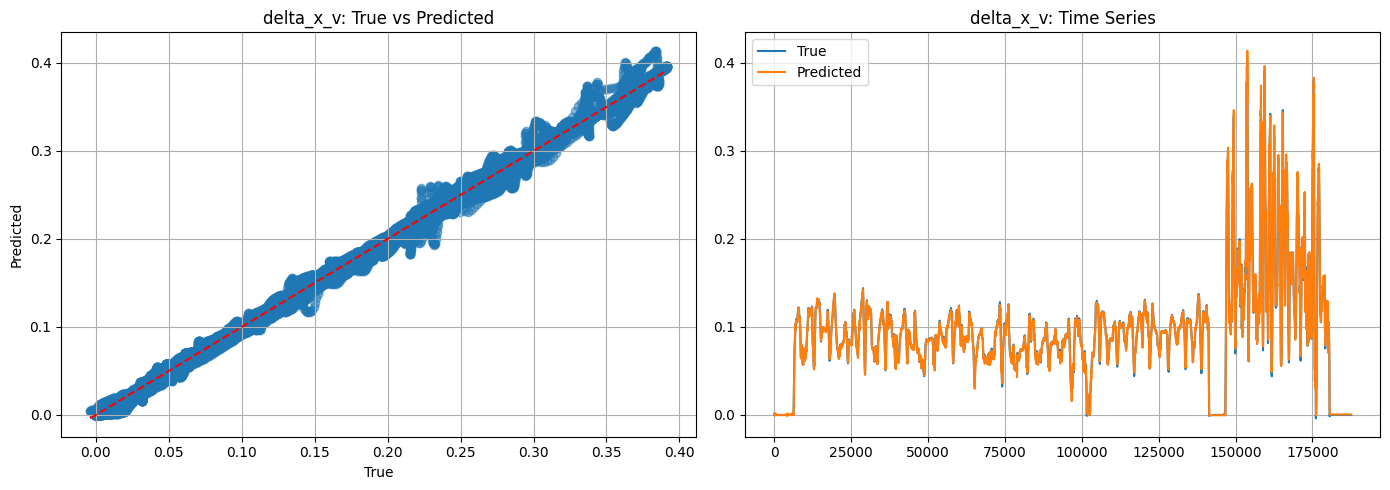


--- delta_y_v ---
MSE : 0.0000
RMSE: 0.0007
MAE : 0.0003
R²  : 0.8905


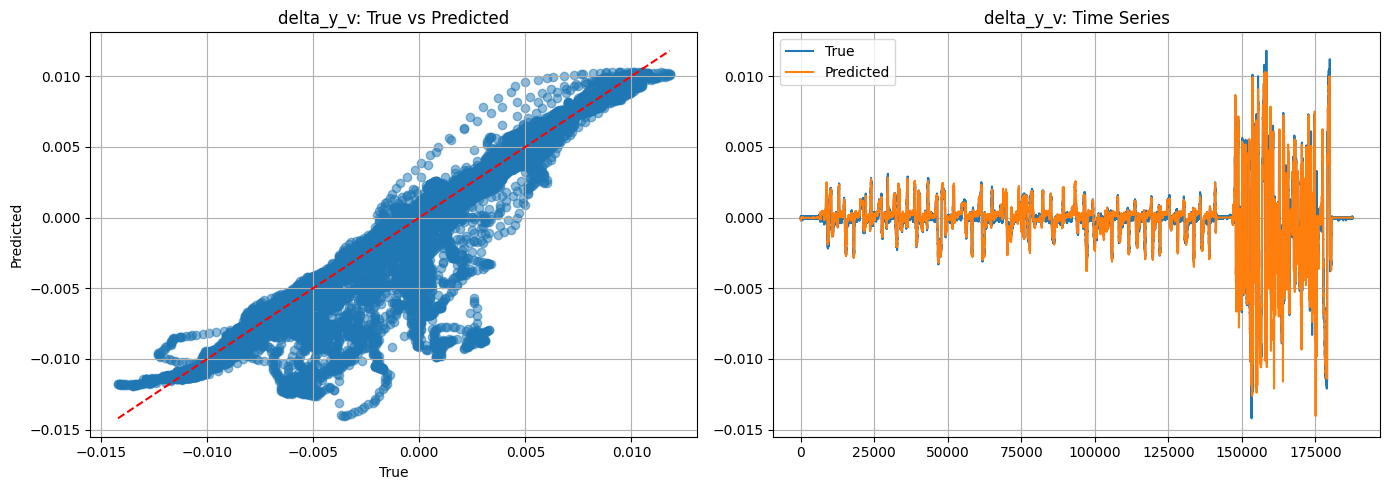

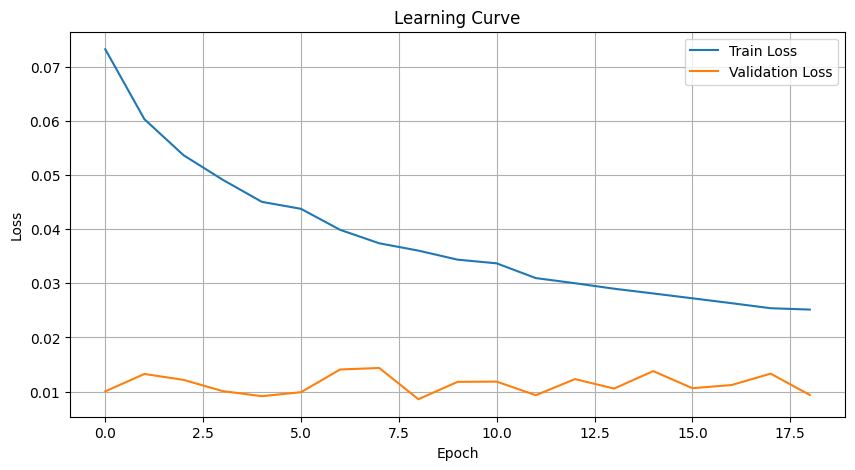

In [11]:
# Metrics and plots
metrics = {}
for i, name in enumerate(target_columns):
    y_true = targets_unscaled[:, i]
    y_pred = preds_unscaled[:, i]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics[name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

    print(f"\n--- {name} ---")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    axes[0].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    axes[0].set_title(f'{name}: True vs Predicted')
    axes[0].set_xlabel('True')
    axes[0].set_ylabel('Predicted')
    axes[0].grid(True)

    axes[1].plot(y_true, label='True')
    axes[1].plot(y_pred, label='Predicted')
    axes[1].set_title(f'{name}: Time Series')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()



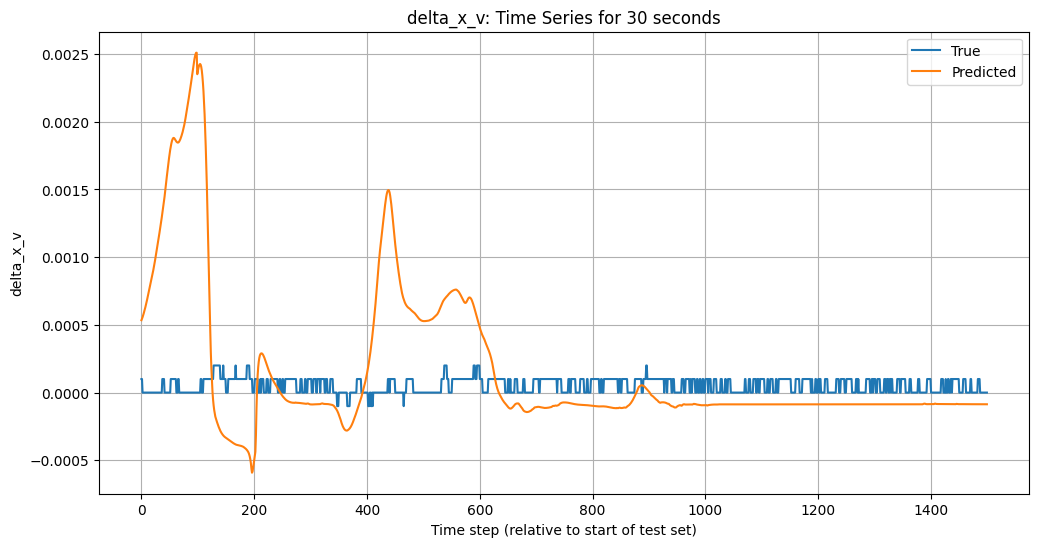

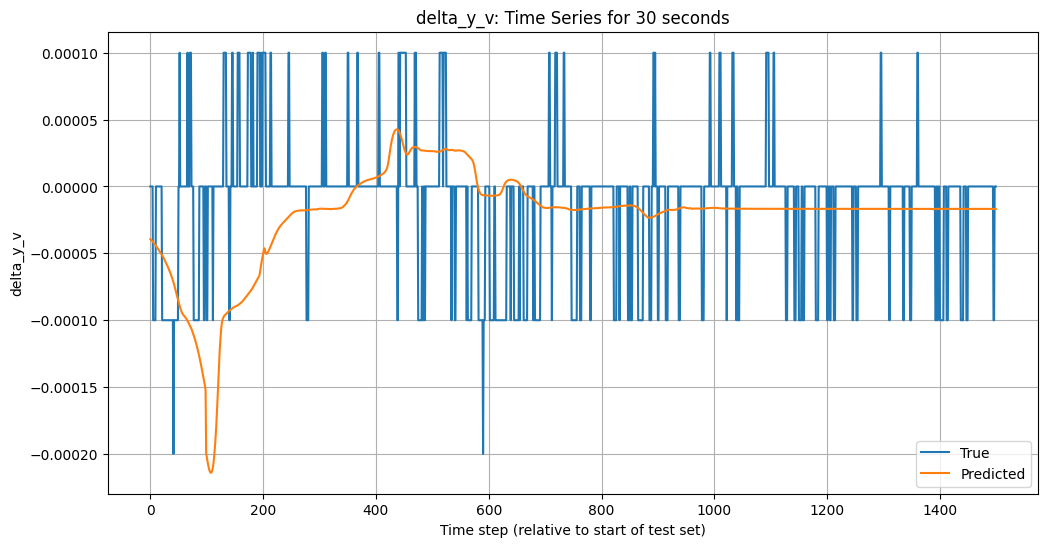

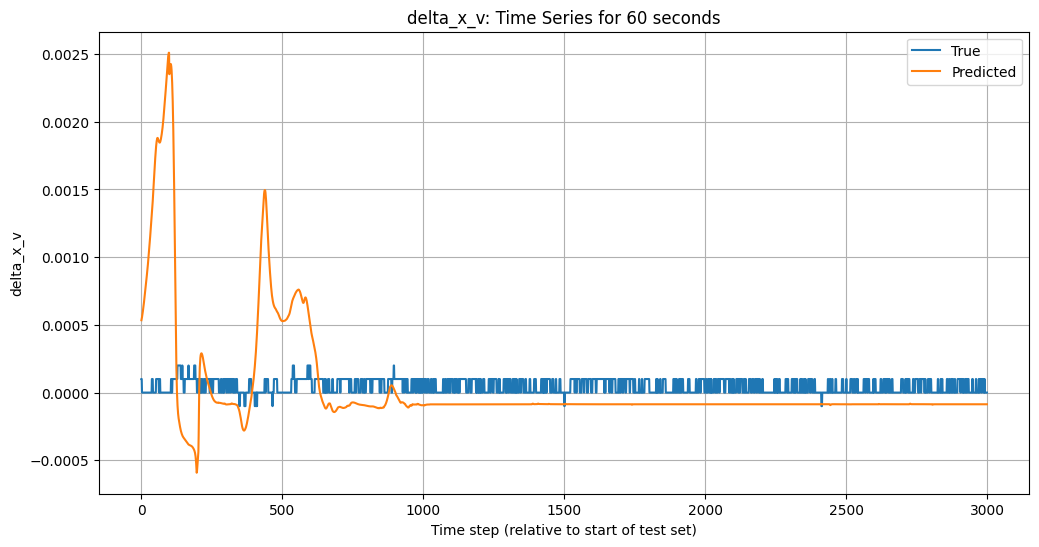

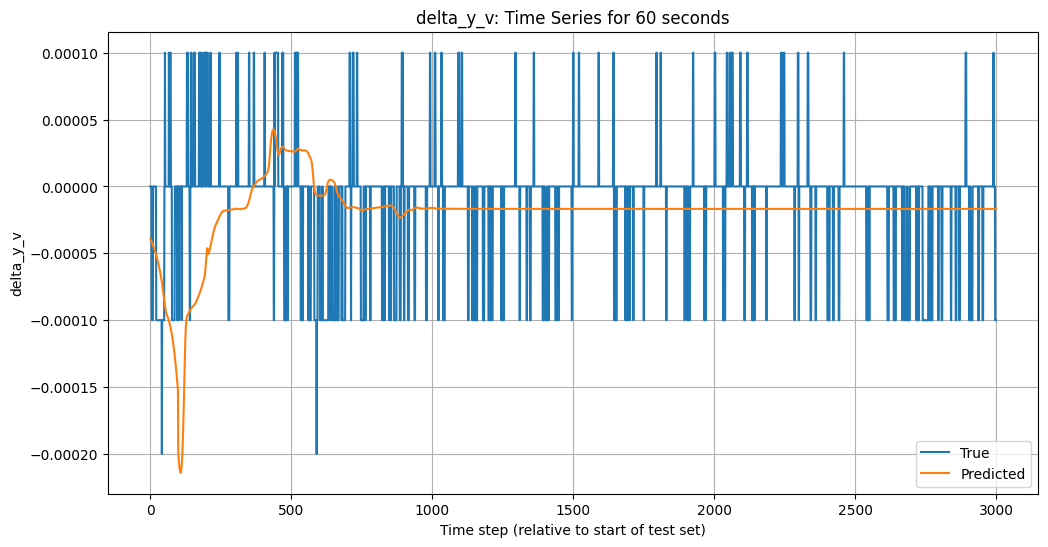

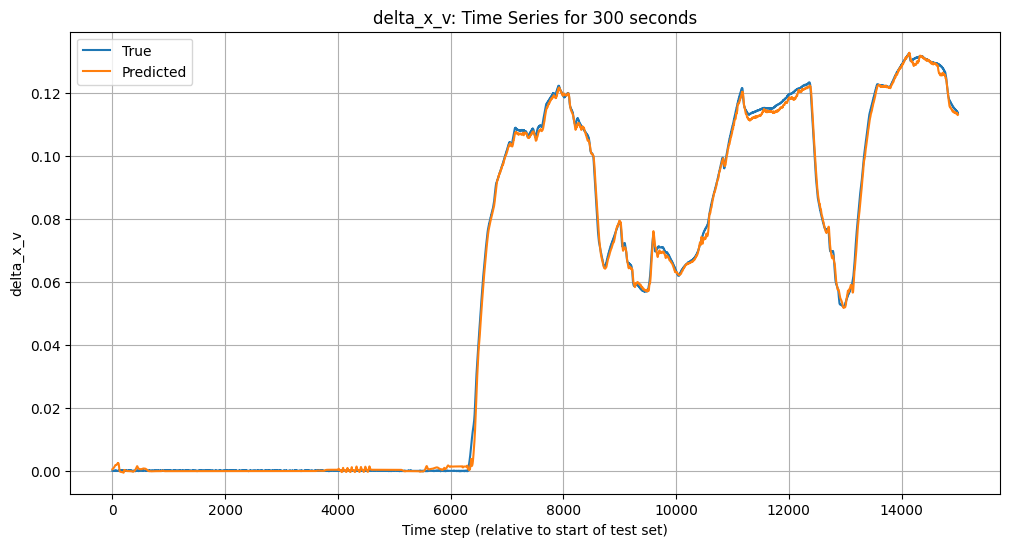

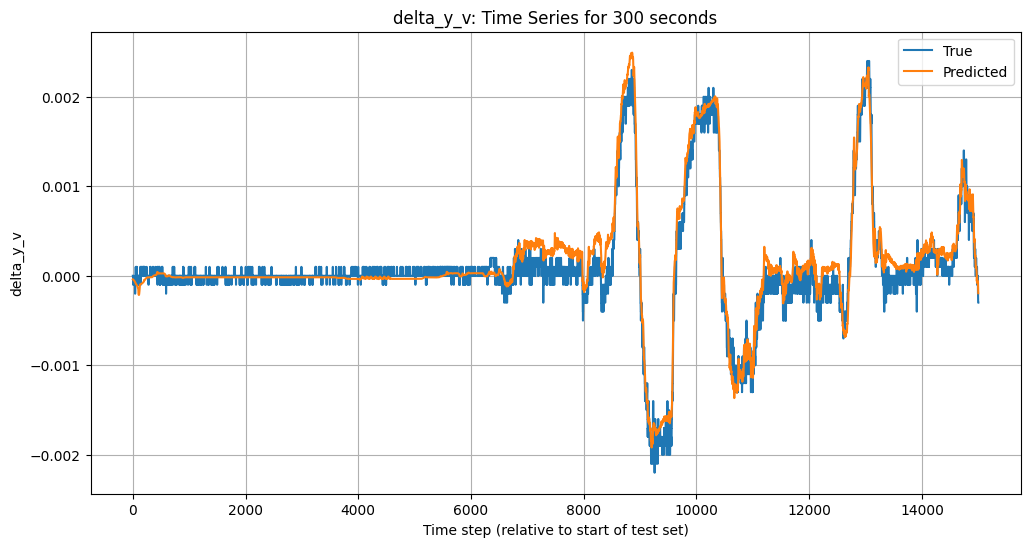

In [39]:
# --- Plotting Time Series for Deltas for Specific Durations ---

# Ensure you have run the previous cells that generate
# targets_unscaled and preds_unscaled

sampling_frequency = 50 # Hz
durations_seconds = [30, 60, 5 * 60] # Durations in seconds: 30s, 60s, 5 minutes

# Identify the indices of the delta columns in target_columns
delta_column_names = ['delta_x_v', 'delta_y_v']
delta_column_indices = [target_columns.index(name) for name in delta_column_names if name in target_columns]

if not delta_column_indices:
    print("Error: 'delta_x_v' or 'delta_y_v' not found in target_columns.")
else:
    for duration in durations_seconds:
        num_timesteps = duration * sampling_frequency

        # Slice the true and predicted data for the current duration
        targets_segment = targets_unscaled[:num_timesteps, :]
        preds_segment = preds_unscaled[:num_timesteps, :]

        # Iterate only over the indices of the delta columns
        for idx in delta_column_indices:
            name = target_columns[idx] # Get the name of the current delta column

            y_true_segment = targets_segment[:, idx]
            y_pred_segment = preds_segment[:, idx]

            plt.figure(figsize=(12, 6))
            plt.plot(y_true_segment, label='True')
            plt.plot(y_pred_segment, label='Predicted')
            plt.xlabel(f'Time step (relative to start of test set)')
            plt.ylabel(name)
            plt.title(f'{name}: Time Series for {duration} seconds')
            plt.legend()
            plt.grid(True)
            plt.show()


<Figure size 1000x800 with 0 Axes>

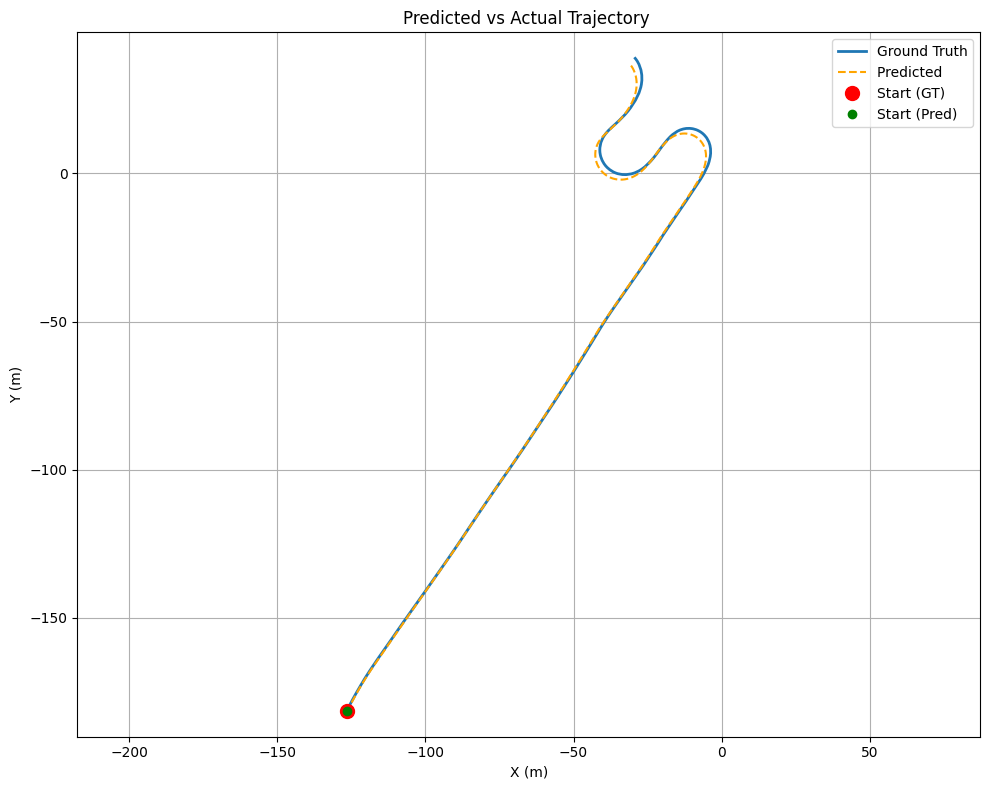

In [ ]:
# Trajectory reconstruction for the first x seconds of the test set
num_timesteps = 200 * 50 #accurately first at 150 till 290 

yaw_segment = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
yaw_segment = -np.deg2rad(yaw_segment) # Ensure the yaw is in radians and potentially negated based on your coordinate system

pred_dx_v_segment = preds_unscaled[:num_timesteps, 2]
pred_dy_v_segment = preds_unscaled[:num_timesteps, 3]

# Rotate deltas to the fixed frame for the segment
delta_x_f_segment = pred_dx_v_segment * np.cos(yaw_segment) - pred_dy_v_segment * np.sin(yaw_segment)
delta_y_f_segment = pred_dx_v_segment * np.sin(yaw_segment) + pred_dy_v_segment * np.cos(yaw_segment) # Corrected sin angle

# Get the starting point of the test set
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]

# Calculate predicted trajectory for the segment
pred_pos_x_segment = np.cumsum(delta_x_f_segment) + start_x
pred_pos_y_segment = np.cumsum(delta_y_f_segment) + start_y

# Get ground truth trajectory for the segment
gt_pos_x_segment = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]
gt_pos_y_segment = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + num_timesteps]

plt.figure(figsize=(10, 8))


plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x_segment, gt_pos_y_segment, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x_segment, pred_pos_y_segment, label='Predicted ', linestyle='--', color='orange')
plt.plot(gt_pos_x_segment[0], gt_pos_y_segment[0], 'ro', markersize=10, label='Start (GT)')
plt.plot(pred_pos_x_segment[0], pred_pos_y_segment[0], 'go', markersize=6, label='Start (Pred)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory ')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

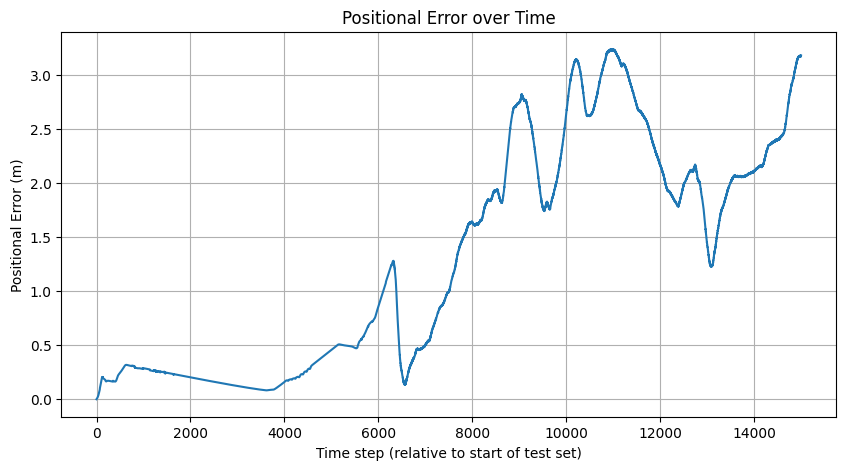

Significant deviation starts around time step: 8690
Corresponding time in minutes: 2.90 minutes


In [41]:
# Calculate error
error = np.sqrt((pred_pos_x_segment - gt_pos_x_segment)**2 + (pred_pos_y_segment - gt_pos_y_segment)**2)

# Plot error over time
plt.figure(figsize=(10, 5))
plt.plot(error)
plt.xlabel('Time step (relative to start of test set)')
plt.ylabel('Positional Error (m)')
plt.title('Positional Error over Time')
plt.grid(True)
plt.show()

# Find time of significant deviation
error_threshold = 2
deviation_start_index = np.argmax(error > error_threshold)

if deviation_start_index > 0:
    print(f"Significant deviation starts around time step: {deviation_start_index}")
else:
    print("No significant deviation above the threshold observed.")

corresponding_time = deviation_start_index / (50 * 60)  #in minutes
print(f"Corresponding time in minutes: {corresponding_time:.2f} minutes")

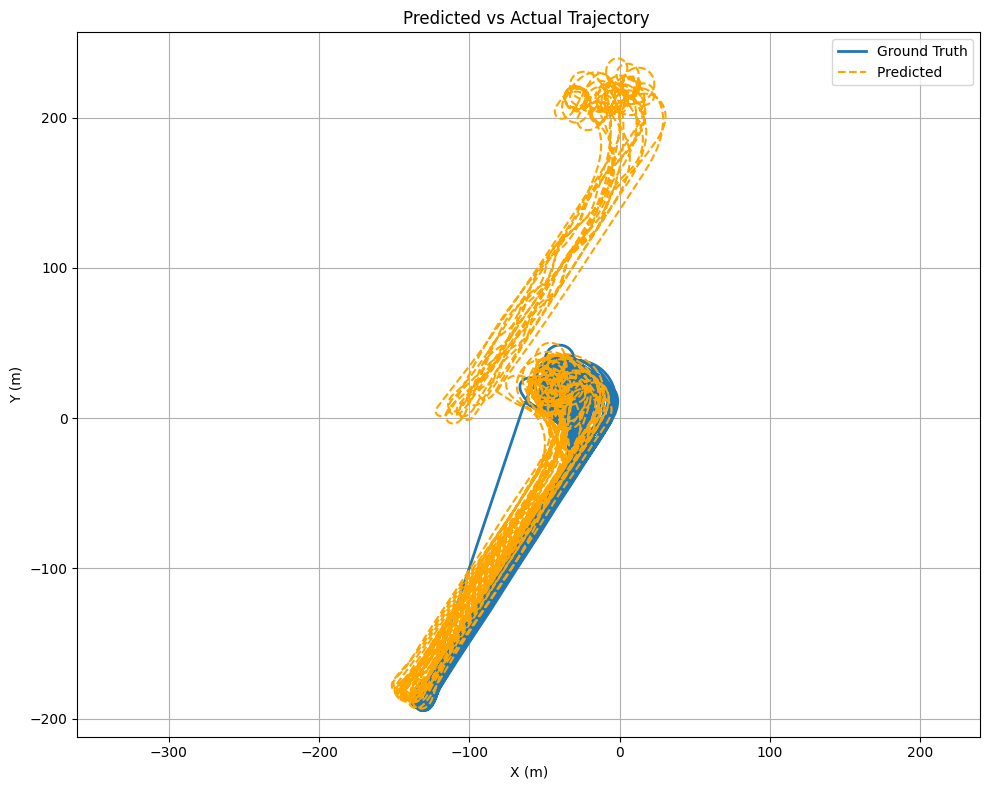

In [18]:
# Trajectory reconstruction
yaw = df['ins_yaw'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + len(preds_unscaled)]
yaw = -np.deg2rad(yaw)

pred_dx_v = preds_unscaled[:, 2]
pred_dy_v = preds_unscaled[:, 3]

#converting to global frame
delta_x_f = pred_dx_v * np.cos(yaw) - pred_dy_v * np.sin(yaw)
delta_y_f = pred_dx_v * np.sin(yaw) + pred_dy_v * np.cos(yaw)

#initial position
start_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size]
start_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size]

# Cumulative sum to get the trajectory
pred_pos_x = np.cumsum(delta_x_f) + start_x
pred_pos_y = np.cumsum(delta_y_f) + start_y


gt_pos_x = df['ins_pos_rel_x'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + len(preds_unscaled)]
gt_pos_y = df['ins_pos_rel_y'].values[seq_len + train_size + val_size : seq_len + train_size + val_size + len(preds_unscaled)]

plt.figure(figsize=(10, 8))
plt.plot(gt_pos_x, gt_pos_y, label='Ground Truth', linewidth=2)
plt.plot(pred_pos_x, pred_pos_y, label='Predicted ', linestyle='--', color='orange')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Predicted vs Actual Trajectory ')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


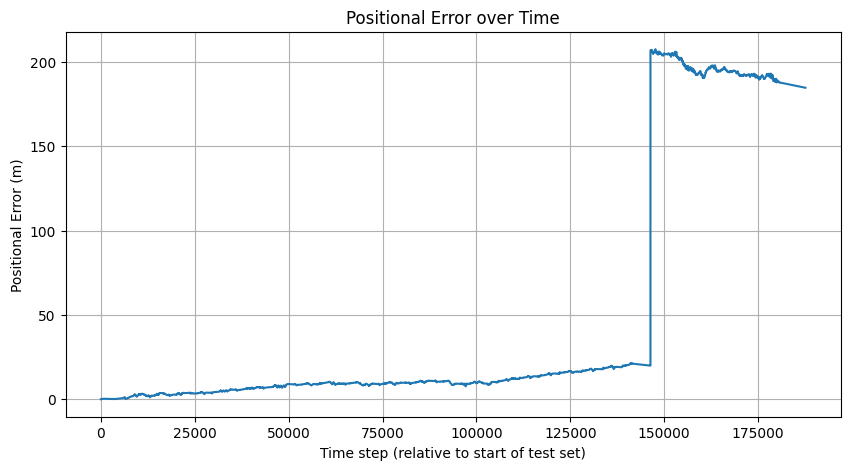

Significant deviation starts around time step: 6105


In [31]:
# Calculate error
error = np.sqrt((pred_pos_x - gt_pos_x)**2 + (pred_pos_y - gt_pos_y)**2)

# Plot error over time
plt.figure(figsize=(10, 5))
plt.plot(error)
plt.xlabel('Time step (relative to start of test set)')
plt.ylabel('Positional Error (m)')
plt.title('Positional Error over Time')
plt.grid(True)
plt.show()

# Find time of significant deviation
error_threshold = 1.0
deviation_start_index = np.argmax(error > error_threshold)

if deviation_start_index > 0:
    print(f"Significant deviation starts around time step: {deviation_start_index}")
else:
    print("No significant deviation above the threshold observed.")